In [1]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax

class WaveEquation2D(Problem):
    """Solves the time-dependent 1D viscous Burgers equation
        d^2 u       d^2 u    
        ----- - c^2 ----- = 0
        d t^2       d x^2    

        for (x, t) in [0, 1]^2

        Boundary conditions:
        u(0, t) = 0
        u(1, t) = 0
        u(x, 0) = sin(πx) + 0.5 sin(4πx)
        u_t(x, 0) = 0
    """

    @staticmethod
    def init_params(c=jnp.sqrt(2), sd=0.1):

        static_params = {
            "dims":(1,2),
            "c":c,
            "sd":sd,
            }
        
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh(x/sd) * tanh((1-x)/sd) * t**2 * u  + (sin(pi*x) + 0.5 * sin(4*pi*x))
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx
        mse = jnp.mean(phys**2)
        return mse, phys
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        c = all_params["static"]["problem"]["c"]
        x, t, sin, cos, pi = x_batch[:,0:1], x_batch[:,1:2], jnp.sin, jnp.cos, jnp.pi
        u = sin(pi*x)*cos(c*pi*t) + 0.5 * sin(4*pi*x)*cos(4*c*pi*t)
        return u

[INFO] 2025-05-23 13:20:18 - <fbpinns.constants.Constants object at 0x7abb5c2d2d80>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 5.0)}
network: <class 'fbpinns.networks.AdaptiveChebyshevKAN'>
network_init_kwargs: {'in_dim': 2, 'out_dim': 1, 'degree': 6}
n_steps: 25000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200, 200),)
n_test: (200, 200)
sampler: grid
optimiser: <function adam at 0x7abc1ad07560>
optimiser_kwargs: {'learning_rate': 0.01}
seed: 0
summary_freq: 1000
test_f

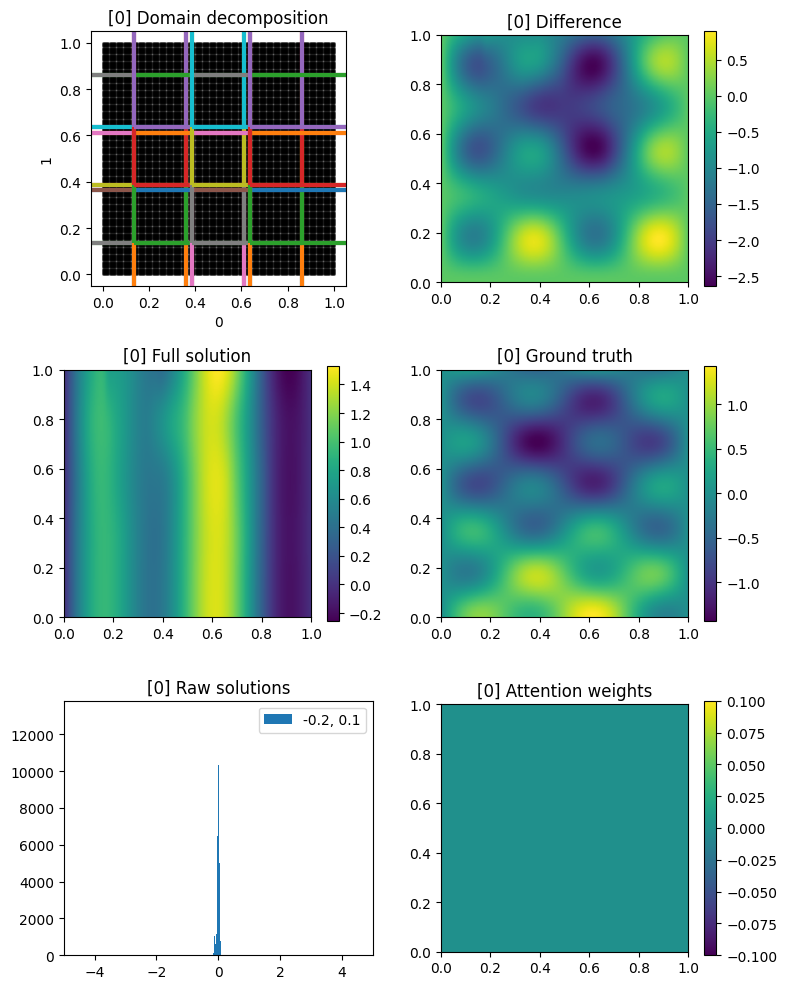

[INFO] 2025-05-23 13:20:58 - [i: 1000/25000] loss: 365.0974 rate: 37.7 elapsed: 0.01 hr test
[INFO] 2025-05-23 13:21:15 - [i: 2000/25000] loss: 312.1864 rate: 59.5 elapsed: 0.01 hr test
[INFO] 2025-05-23 13:21:31 - [i: 3000/25000] loss: 302.1969 rate: 61.7 elapsed: 0.02 hr test
[INFO] 2025-05-23 13:21:42 - [i: 4000/25000] loss: 301.0233 rate: 89.7 elapsed: 0.02 hr test
[INFO] 2025-05-23 13:21:56 - [i: 5000/25000] loss: 299.8501 rate: 73.9 elapsed: 0.02 hr test
[INFO] 2025-05-23 13:21:56 - saved arrays


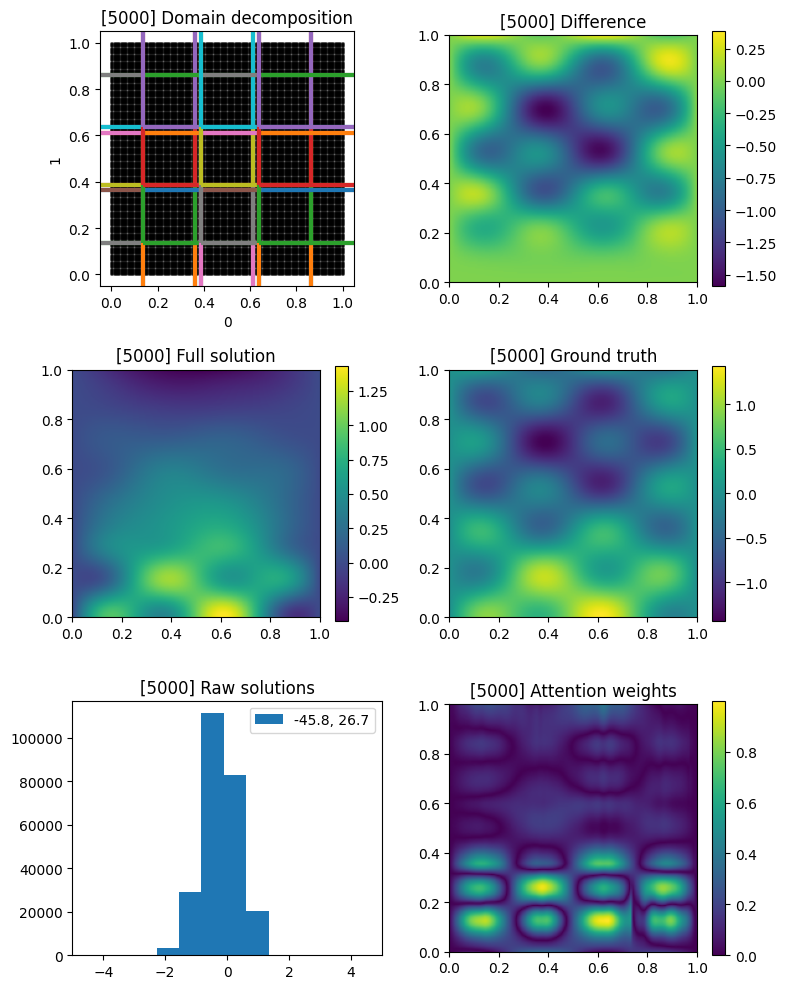

[INFO] 2025-05-23 13:22:14 - [i: 6000/25000] loss: 297.1213 rate: 59.9 elapsed: 0.03 hr test
[INFO] 2025-05-23 13:22:29 - [i: 7000/25000] loss: 280.6651 rate: 64.6 elapsed: 0.03 hr test
[INFO] 2025-05-23 13:22:40 - [i: 8000/25000] loss: 261.8133 rate: 90.2 elapsed: 0.04 hr test
[INFO] 2025-05-23 13:22:55 - [i: 9000/25000] loss: 241.7221 rate: 70.1 elapsed: 0.04 hr test
[INFO] 2025-05-23 13:23:12 - [i: 10000/25000] loss: 220.2248 rate: 59.2 elapsed: 0.05 hr test
[INFO] 2025-05-23 13:23:12 - saved arrays


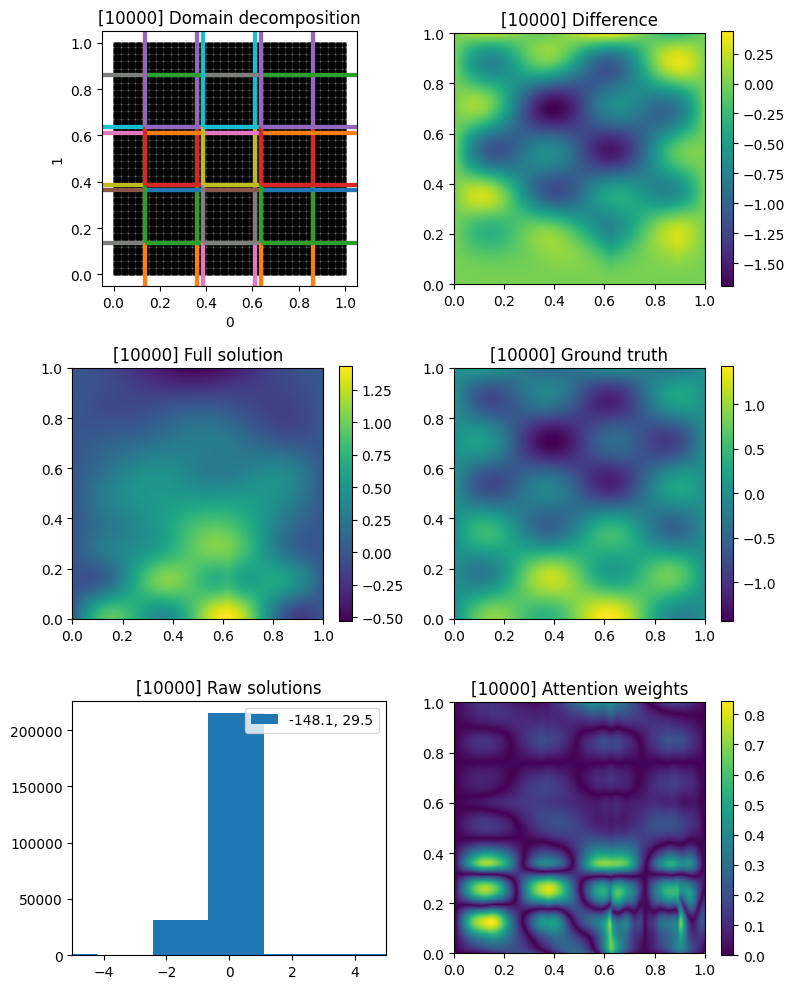

[INFO] 2025-05-23 13:23:28 - [i: 11000/25000] loss: 237.9521 rate: 69.8 elapsed: 0.05 hr test
[INFO] 2025-05-23 13:23:39 - [i: 12000/25000] loss: 242.5313 rate: 89.6 elapsed: 0.05 hr test


KeyboardInterrupt: 

In [2]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, ChebyshevAdaptiveKAN, StackedChebyshevKAN, FractionalChebyshevKAN, AdaptiveChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,5.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 16, 1),
    # ),
    # network=StackedChebyshevKAN,
    # network_init_kwargs=dict(
    #     input_dim=2,
    #     hidden_dim=4,
    #     output_dim=1,
    #     degree=6
    # ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    network=AdaptiveChebyshevKAN,
    network_init_kwargs=dict(
        in_dim=2,
        out_dim=1,
        degree=6
    ),
    # network_init_kwargs = dict(
    #     dims=[2, 4, 1],
    #     degrees=[4, 4]
    # ),
    optimiser_kwargs = dict(
        learning_rate=0.01
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=25000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

In [ ]:
all_params

{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2),
   'c': Array(1.4142135, dtype=float32, weak_type=True),
   'sd': 0.1},
  'decomposition': {'m': 100,
   'xd': 2,
   'subdomain': {'params': [Array([[-0.16111112, -0.16111112],
            [-0.16111112, -0.05      ],
            [-0.16111112,  0.06111111],
            [-0.16111112,  0.17222223],
            [-0.16111112,  0.28333333],
            [-0.16111112,  0.39444444],
            [-0.16111112,  0.50555557],
            [-0.16111112,  0.6166667 ],
            [-0.16111112,  0.7277778 ],
            [-0.16111112,  0.8388889 ],
            [-0.05      , -0.16111112],
            [-0.05      , -0.05      ],
            [-0.05      ,  0.06111111],
            [-0.05      ,  0.17222223],
            [-0.05      ,  0.28333333],
            [-0.05      ,  0.39444444],
            [-0.05      ,  0.50555557],
            [-0.05      ,  0.61666